Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Fetal Planes Classification Tutorial

This tutorial demonstrates how to use MONAI for medical image classification on the **FETAL_PLANES_DB** dataset.

**Dataset**: Fetal ultrasound plane classification (6 classes: Abdomen, Brain, Femur, Thorax, Cervix, Other)
**Task:** Classification

**Dataset Link**: [https://zenodo.org/records/3904280](https://zenodo.org/records/3904280)

**Dataset Journal Article**: [Evaluation of deep convolutional neural networks for automatic classification of common maternal fetal ultrasound planes](https://www.nature.com/articles/s41598-020-67076-5)

This tutorial covers:
1. Downloading Dataset
2. Importing the required libraries
3. Dataset Loading and Cleaning
4. Data Transforms and initializing Dataset and Dataloader classes
5. Classification Model Setup
6. Training Loop with Validation
7. Visualization of Results
8. Model Evaluation

In [1]:
# Install required packages
!pip install monai[all]

## 1. Downloading Dataset

In [2]:
import os
import zipfile
from pathlib import Path

DATASET_URL = "https://zenodo.org/records/3904280/files/FETAL_PLANES_ZENODO.zip?download=1"
ZIP_FILE_NAME = "fetal_planes.zip"
dataset_folder = Path("data/fetal_planes")

if os.path.exists(ZIP_FILE_NAME) or dataset_folder.exists():
    print("Dataset already exists (zip file or extracted folder found). Skipping download.")
else:
    !wget {DATASET_URL} -O {ZIP_FILE_NAME}
    print("Dataset downloaded successfully!")

Dataset already exists (zip file or extracted folder found). Skipping download.


Extracting the downloaded dataset zip file to data/fetal_planes

In [3]:
# Check if folder already exists
if dataset_folder.exists():
    print("Dataset folder already exists. Skipping extraction.")
elif os.path.exists(ZIP_FILE_NAME):
    # Create data directory if it doesn't exist
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)
    
    # Extract to data/fetal_planes
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Dataset extracted successfully to data/fetal_planes!")
else:
    print("Zip file not found. Please download the dataset first.")

Dataset folder already exists. Skipping extraction.


# 2. Importing the required libraries

In [4]:
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# MONAI imports
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    Resize,
    ScaleIntensityRange,
    NormalizeIntensity,
    EnsureType,
    RandRotate,
    RandAdjustContrast,
    RandShiftIntensity
)
from monai.networks.nets import EfficientNetBN
from monai.utils import set_determinism
import random
import numpy as np

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_determinism(seed=seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using device: cuda


# 3. Dataset Loading and Cleaning

In [5]:
csv_path = dataset_folder / "FETAL_PLANES_DB_data.csv"

df = pd.read_csv(csv_path, sep=';')

# The CSV file has a space in the 'Train ' column name, so we trim it to 'Train' only
if 'Train ' in df.columns:
    df.rename(columns={'Train ': 'Train'}, inplace=True)

classes = sorted(df['Plane'].unique())
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")
print(f"\nTotal samples: {len(df)}")
print(f"\nTrain/Test split:")
print(df['Train'].value_counts())

Number of classes: 6
Classes: ['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax', 'Maternal cervix', 'Other']

Total samples: 12400

Train/Test split:
Train
1    7129
0    5271
Name: count, dtype: int64


### Dataset Structure

The downloaded dataset contains the following structure:

- **CSV file** (`FETAL_PLANES_DB_data.csv`): Contains metadata for each image with columns:
  - `Image_name`: Name of the image file
  - `Patient_num`: Patient identifier
  - `Plane`: Class label (one of: Fetal abdomen, Fetal brain, Fetal femur, Fetal thorax, Maternal cervix, Other)
  - `Brain_plane`: Additional brain plane classification
  - `Operator`: Operator identifier
  - `US_Machine`: Ultrasound machine type
  - `Train`: Binary indicator (1 for training, 0 for validation/test)

- **Images folder**: Contains PNG image files named according to `Image_name` from the CSV

The dataset is pre-split into training and validation sets using the `Train` column.

In [6]:
df.head()

,Image_name,Patient_num,Plane,Brain_plane,Operator,US_Machine,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,Other,Aloka,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,Other,Aloka,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,Other,Aloka,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,Other,Aloka,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,Other,Aloka,1


Adding column `image_path` and `class_idx` to the dataframe

In [7]:
# Create image paths and labels
df['image_path'] = df['Image_name'].apply(lambda x: str(dataset_folder / "Images" / f"{x}.png"))
df['class_idx'] = df['Plane'].map(class_to_idx)

Some of the images in the dataset are not grayscale and will cause errors in the training process, so we need to filter them out.

In [8]:
from PIL import Image

problematic_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row['image_path']
    image = Image.open(image_path)
    if image.mode != 'L':
        problematic_indices.append(idx)

print(f"Found {len(problematic_indices)} problematic images")

# Remove problematic images from dataframe
df = df.drop(problematic_indices)

# Reset index
df = df.reset_index(drop=True)

100%|██████████| 12400/12400 [00:01<00:00, 10285.88it/s]

Found 45 problematic images


Split into train and validation based on 'Train' column. Train=1 means training set, Train=0 means test set

In [9]:
train_df = df[df['Train'] == 1].copy()
val_df = df[df['Train'] == 0].copy()

# Filter out Patient 1 (has 4-channel RGBA images instead of grayscale)
train_df = train_df[train_df['Patient_num'] != 1].copy()
val_df = val_df[val_df['Patient_num'] != 1].copy()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nClass distribution in training set:")
print(train_df['Plane'].value_counts())

Training samples: 7114
Validation samples: 5235

Class distribution in training set:
Plane
Other              2586
Fetal brain        1620
Fetal thorax       1058
Maternal cervix     981
Fetal femur         516
Fetal abdomen       353
Name: count, dtype: int64


## 4. Data Transforms and initializing Dataset and Dataloader classes

In [10]:
# Create a MONAI-compatible Dataset class
class FetalPlanesDataset(Dataset):
    """
    Custom dataset class for fetal planes classification.
    Returns dictionary with 'image' and 'label' keys for MONAI compatibility.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        data = {"image_path": image_path}

        # Apply transforms if provided
        if self.transform:
            data["image"] = self.transform(data["image_path"])
        
        # Ensure label is a tensor
        data['label'] = torch.tensor(label, dtype=torch.long)
        
        return data

### Data Transforms/Augmentations

The following transforms are applied to preprocess the images:

**Training transforms:**
- `LoadImage`: Loads the image from file path
- `EnsureChannelFirst`: Ensures the channel dimension is first (required for MONAI)
- `Resize`: Resizes images to 224x224 pixels
- `ScaleIntensityRange`: Scales pixel values from [0, 255] to [0, 1] range
- `RandAdjustContrast`: Random contrast adjustment (gamma between 0.8-1.2, 50% probability) - simulates different gain settings
- `RandShiftIntensity`: Random brightness adjustment (offset ±0.1, 50% probability) - simulates different brightness levels
- `NormalizeIntensity`: Applies ImageNet normalization
- `EnsureType`: Converts to PyTorch tensor

**Validation transforms:** Same as training, but without data augmentation to ensure consistent evaluation.

The augmentation transforms help improve model generalization by exposing it to variations in orientation and intensity that may occur in real-world ultrasound images.

In [ ]:
train_transforms = Compose([
    LoadImage(reverse_indexing=False),  # For image files setting reverse_indexing to False to False will prevent the image from being transposed
    EnsureChannelFirst(),
    Resize(spatial_size=(224, 224)),
    # Scale intensity before applying intensity augmentations
    ScaleIntensityRange(a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
    RandAdjustContrast(gamma=(0.8, 1.2), prob=0.5),  # Random contrast adjustment
    RandShiftIntensity(offsets=0.1, prob=0.5),  # Random brightness adjustment
    NormalizeIntensity(subtrahend=[0.445], divisor=[0.269], channel_wise=True),  # ImageNet normalization (grayscale)
    EnsureType(data_type="tensor")
])

In [12]:
val_transforms = Compose([
    LoadImage(reverse_indexing=False),
    EnsureChannelFirst(),
    Resize(spatial_size=(224, 224)),
    ScaleIntensityRange(a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
    NormalizeIntensity(subtrahend=[0.445], divisor=[0.269], channel_wise=True),
    EnsureType(data_type="tensor")
])

In [13]:
train_dataset = FetalPlanesDataset(
    image_paths=train_df['image_path'].tolist(),
    labels=train_df['class_idx'].tolist(),
    transform=train_transforms
)

val_dataset = FetalPlanesDataset(
    image_paths=val_df['image_path'].tolist(),
    labels=val_df['class_idx'].tolist(),
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 223
Validation batches: 164


## 5. Classification Model Setup

In [14]:
model_name = "efficientnet-b0"
model = EfficientNetBN(
    model_name=model_name,
    spatial_dims=2,
    in_channels=1,
    num_classes=num_classes,
    pretrained=True
).to(device)

print(f"Model: {model_name}")
print(f"Input channels: 1 (grayscale)")
print(f"Output channels: {num_classes} (classes)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: efficientnet-b0
Input channels: 1 (grayscale)
Output channels: 6 (classes)
Total parameters: 4,014,658


## 6. Training Loop with Validation

In [15]:
criterion = nn.CrossEntropyLoss()

lr = 1e-3
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

train_losses = []
val_losses = []
val_accuracies = []
learning_rates = []
best_val_acc = 0.0
model_path = "best_model.pth" # Path to save the best model

In [16]:
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_acc:
        print(f"New best validation accuracy: {val_accuracy:.2f}%")
        print(f"Saving model to {model_path}")
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), model_path)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

100%|██████████| 164/164 [00:10<00:00, 15.15it/s]


New best validation accuracy: 24.51%
Saving model to best_model.pth
Epoch [1/10]
  Train Loss: 0.4500
  Val Loss: 4.2668
  Val Accuracy: 24.51%
--------------------------------------------------


100%|██████████| 164/164 [00:11<00:00, 14.84it/s]


New best validation accuracy: 86.57%
Saving model to best_model.pth
Epoch [2/10]
  Train Loss: 0.2343
  Val Loss: 0.4011
  Val Accuracy: 86.57%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 15.14it/s]


New best validation accuracy: 88.81%
Saving model to best_model.pth
Epoch [3/10]
  Train Loss: 0.1361
  Val Loss: 0.3902
  Val Accuracy: 88.81%
--------------------------------------------------


100%|██████████| 164/164 [00:11<00:00, 14.91it/s]


New best validation accuracy: 91.65%
Saving model to best_model.pth
Epoch [4/10]
  Train Loss: 0.1021
  Val Loss: 0.3190
  Val Accuracy: 91.65%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 15.17it/s]


Epoch [5/10]
  Train Loss: 0.0669
  Val Loss: 0.3908
  Val Accuracy: 91.23%
--------------------------------------------------


100%|██████████| 164/164 [00:11<00:00, 14.88it/s]


Epoch [6/10]
  Train Loss: 0.0693
  Val Loss: 0.3121
  Val Accuracy: 89.97%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 14.93it/s]


Epoch [7/10]
  Train Loss: 0.0697
  Val Loss: 0.7596
  Val Accuracy: 85.44%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 14.98it/s]


Epoch [8/10]
  Train Loss: 0.1227
  Val Loss: 0.6294
  Val Accuracy: 85.54%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 14.94it/s]


Epoch [9/10]
  Train Loss: 0.0933
  Val Loss: 0.3808
  Val Accuracy: 90.93%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 14.94it/s]


New best validation accuracy: 92.51%
Saving model to best_model.pth
Epoch [10/10]
  Train Loss: 0.0472
  Val Loss: 0.3809
  Val Accuracy: 92.51%
--------------------------------------------------


## 7. Visualization of Results

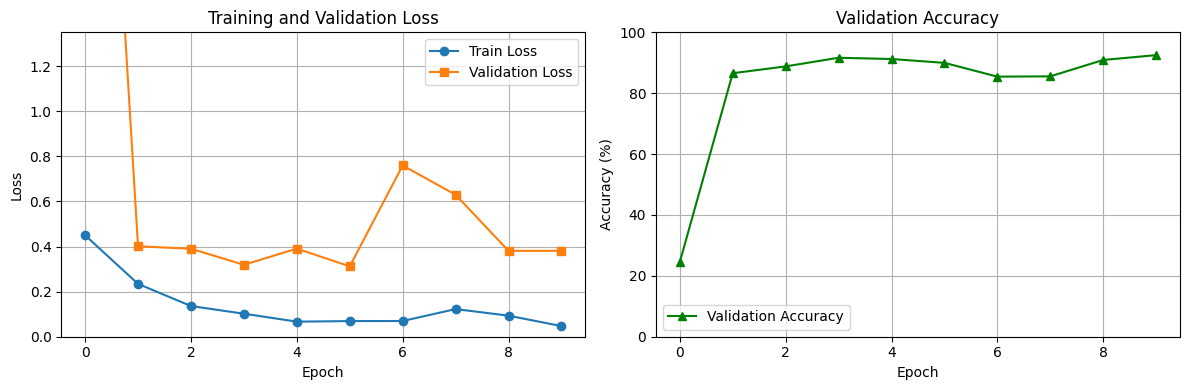

In [17]:
# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3*train_losses[0])
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='^', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Sample Predictions Visualization

The following code cell visualizes model predictions on 6 randomly selected validation samples. For each sample, it displays:
- The ultrasound image
- The true label (ground truth)
- The predicted label
- The prediction confidence (as a percentage)

Images with correct predictions are shown with green titles, while incorrect predictions are shown in red. This visualization helps assess the model's performance qualitatively and identify potential failure cases.

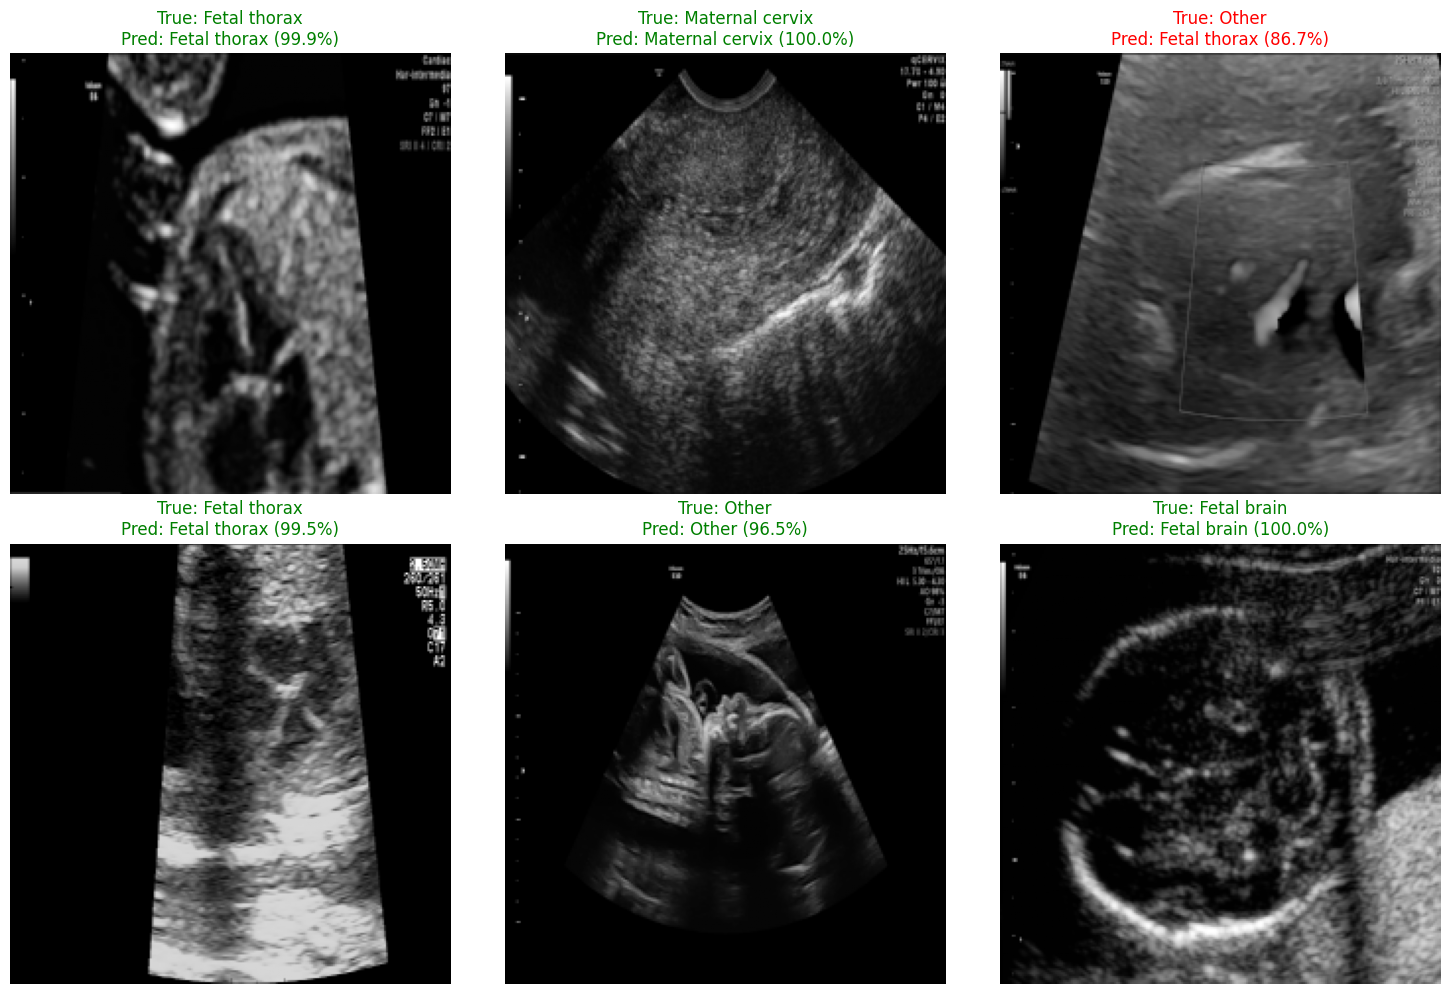

In [18]:
model.load_state_dict(torch.load(model_path))
model.eval()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

import random

rand_indices = random.sample(range(len(val_dataset)), 6)
samples = [val_dataset[i] for i in rand_indices]

images = torch.stack([s['image'] for s in samples]).to(device)
labels = torch.tensor([s['label'] for s in samples])

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.softmax(outputs, dim=1)

for i in range(6):
    img = images[i].cpu().squeeze().numpy()
    true_label = classes[labels[i].item()]
    pred_label = classes[predicted[i].item()]
    confidence = probabilities[i][predicted[i]].item() * 100
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                      color='green' if true_label == pred_label else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8. Model Evaluation

### Metrics and Results

This section evaluates the trained model on the validation set using several metrics:

**Metrics Used:**
- **Accuracy**: Overall percentage of correct predictions
- **Classification Report**: Provides per-class metrics including:
  - **Precision**: Ratio of true positives to all predicted positives (how many of the predicted class X were actually class X)
  - **Recall**: Ratio of true positives to all actual positives (how many of actual class X were correctly identified)
  - **F1-Score**: Harmonic mean of precision and recall
  - **Support**: Number of samples in each class
- **Confusion Matrix**: Visual representation of prediction vs. actual labels, showing which classes are commonly confused

**Expected Results:**
The model typically achieves high accuracy (>85%) on this dataset. Some classes (like "Fetal brain" and "Maternal cervix") tend to have higher precision and recall, while others may show more confusion. The confusion matrix helps identify common misclassification patterns, which can guide further model improvements or data collection strategies.

In [19]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")

100%|██████████| 164/164 [00:10<00:00, 15.10it/s]

Final Validation Accuracy: 92.51%


In [20]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.88      0.90      0.89       358
    Fetal brain       0.97      1.00      0.98      1472
    Fetal femur       0.87      0.88      0.88       524
   Fetal thorax       0.84      0.97      0.90       660
Maternal cervix       1.00      0.99      0.99       637
          Other       0.92      0.84      0.88      1584

       accuracy                           0.93      5235
      macro avg       0.91      0.93      0.92      5235
   weighted avg       0.93      0.93      0.92      5235



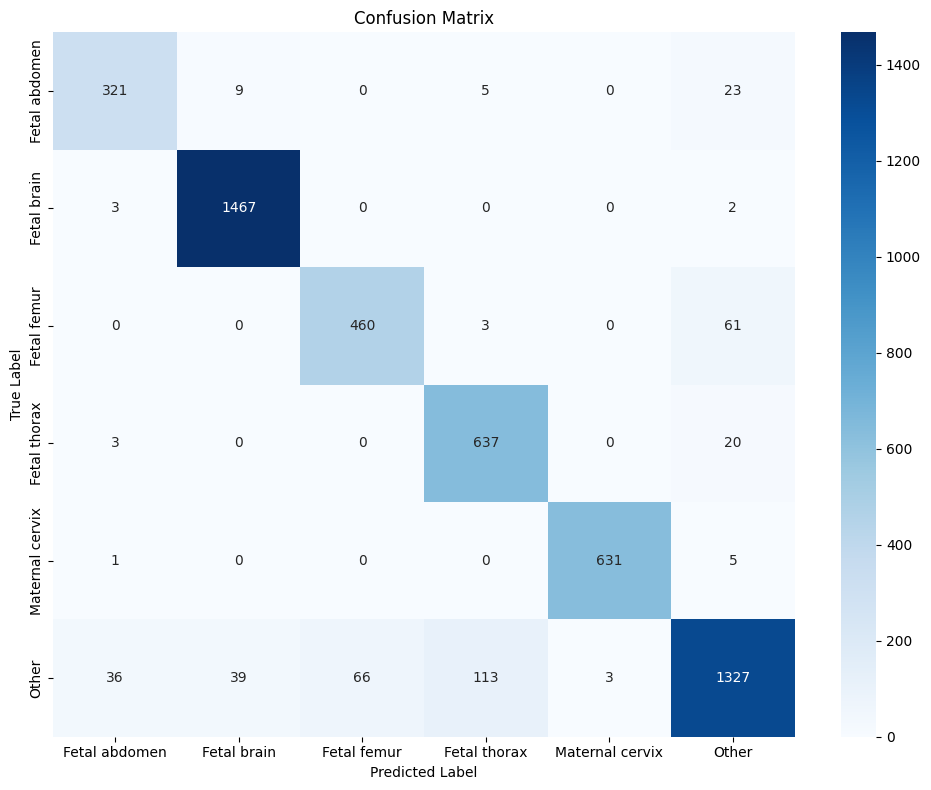

In [21]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()